In [3]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import re
import string

import nltk
from nltk.stem import SnowballStemmer, WordNetLemmatizer
from nltk.corpus import wordnet, stopwords
from nltk.tokenize import word_tokenize
#nltk.download('wordnet')
#nltk.download('punkt')
#nltk.download('stopwords')

In [4]:
def load_stop_words(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        stop_words = set(file.read().splitlines())
    return stop_words

In [5]:
dataset = pd.read_json("dataset\Turkish_data_depository_630koseyazisi.jsonl",lines=True)
print(dataset.head(10))
print(dataset.info())

  writer  file_id                                             column
0    ttu       27  O zaman 28 Şubat neden yapıldı?  \r\n     \r\n...
1    ttu       28  O zaman 28 Şubat neden yapıldı?  \r\n     \r\n...
2    ttu        3  Cumhuriyetin en kritik yerel seçimi \r\nMURAT ...
3    ttu        4  Çekilin artık kamera karşısından \r\nHER kar y...
4    ttu       23  Lorant'ın heyecan veren hedefi  \r\n     \r\n\...
5    ttu       14  Gerçekten de gülüp geçilecek bir öneri \r\nGAZ...
6    ttu       13  Mercedes çeşitlemeleri \r\nTÜRK insanı, Merced...
7    ttu       31  Yazarın çilesi  \r\n     \r\n\r\n  \r\nZAMAN z...
8    ttu       19  Tüm yazı konularını silip süpüren fotoğraf \r\...
9    ttu       11  Şarkta böyledir bu işler...  \r\n     \r\nttu...
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 630 entries, 0 to 629
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   writer   630 non-null    object
 1   file_id  630 non-null

In [6]:
x = dataset.iloc[:, 2].values.astype("str") # author text
y = dataset.iloc[:, 0].values.astype("str") # author name

print(f"type x : {type(x)} , type y : {type(y)}")

type x : <class 'numpy.ndarray'> , type y : <class 'numpy.ndarray'>


In [9]:
stop_words =load_stop_words("stopwordsTR\stopwords.txt") #set(stopwords.words('turkish'))

from TurkishStemmer import TurkishStemmer

# Lemmatizasyon ve stemming işlemleri için hazırlık
stemmer = TurkishStemmer()

nltk.download('punkt')

# Her bir metni lemmatizasyon ve stemming işlemlerinden geçirme
for i in range(len(x)):
    # Convert to lowercase - Küçük harfe çevirme
    x[i] = x[i].lower()
    
    # Remove escape characters - Kaçış karakterlerini kaldırma
    x[i] = re.sub(r'[\r\n]', ' ', x[i]) 
    
    # Remove unnecessary characters - Gereksiz karakterleri kaldırma
    x[i] = re.sub(r'[^a-zA-ZğüşıöçĞÜŞİÖÇ\s]', '', x[i])
    
    # Tokenization - Kelime ayırma
    tokens = word_tokenize(x[i])
    
    # Remove stop words - Stop kelimeleri kaldırma
    filtered_tokens = [word for word in tokens if word not in stop_words]
    x[i] = ' '.join(filtered_tokens)
    
    # Stemming
    stemmed_tokens = [stemmer.stem(word) for word in filtered_tokens]
    x[i] = ' '.join(stemmed_tokens)
    
    # Remove punctuation marks - Noktalama işaretlerini kaldırma
    x[i] = x[i].translate(str.maketrans('', '', string.punctuation))
    
    # Remove repeating spaces - Tekrar eden boşlukları kaldırma
    x[i] = re.sub(r'\s+', ' ', x[i])

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Umitk\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.


In [10]:
# X verisini unigram TF-IDF vektörlerine dönüştürme
vectorizer = TfidfVectorizer(ngram_range=(1, 1))
X_vec = vectorizer.fit_transform(x)

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X_vec, y, test_size=0.2, random_state=42)

In [12]:
from sklearn.model_selection import GridSearchCV, cross_val_score

# SGDClassifier için hiperparametrelerin belirlenmesi
param_grid = {
    'alpha': [1e-05, 0.0001, 0.001],
    'max_iter': [50, 100, 200],
    'penalty': ['elasticnet', 'l2']
}

In [13]:
# GridSearchCV ile model oluşturma
grid_search = GridSearchCV(SGDClassifier(random_state=42), param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

# En iyi parametreleri ve skorları gösterme
print("En iyi parametreler:", grid_search.best_params_)
print("En iyi skor:", grid_search.best_score_)

# Çapraz doğrulama ile model performansını değerlendirme
cross_val_scores = cross_val_score(grid_search, X_test, y_test, cv=5)
print("Çapraz doğrulama skorları:", cross_val_scores)
print("Ortalama çapraz doğrulama skoru:", cross_val_scores.mean())

En iyi parametreler: {'alpha': 0.001, 'max_iter': 50, 'penalty': 'l2'}
En iyi skor: 0.7777425742574258


c:\Users\Umitk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
c:\Users\Umitk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
c:\Users\Umitk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
c:\Users\Umitk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
c:\Users\Umitk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_split.

Çapraz doğrulama skorları: [0.42307692 0.56       0.6        0.72       0.44      ]
Ortalama çapraz doğrulama skoru: 0.5486153846153846


Test accuracy: 0.7540
              precision    recall  f1-score   support

         aar       0.60      0.75      0.67         4
         bco       0.50      0.50      0.50         8
         cul       0.33      0.50      0.40         4
         cun       0.71      1.00      0.83         5
         ebr       0.91      0.91      0.91        11
         gur       0.88      0.88      0.88         8
         hin       0.60      0.50      0.55         6
         kaz       0.80      0.89      0.84         9
         lev       0.60      0.60      0.60         5
         msa       0.83      0.83      0.83         6
         oek       1.00      0.89      0.94         9
         psu       1.00      1.00      1.00        10
         sav       0.60      0.60      0.60         5
         tal       0.71      0.56      0.62         9
         ttu       0.00      0.00      0.00         6
         tug       1.00      1.00      1.00         6
         ved       0.75      0.75      0.75         8
     

c:\Users\Umitk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Umitk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Umitk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

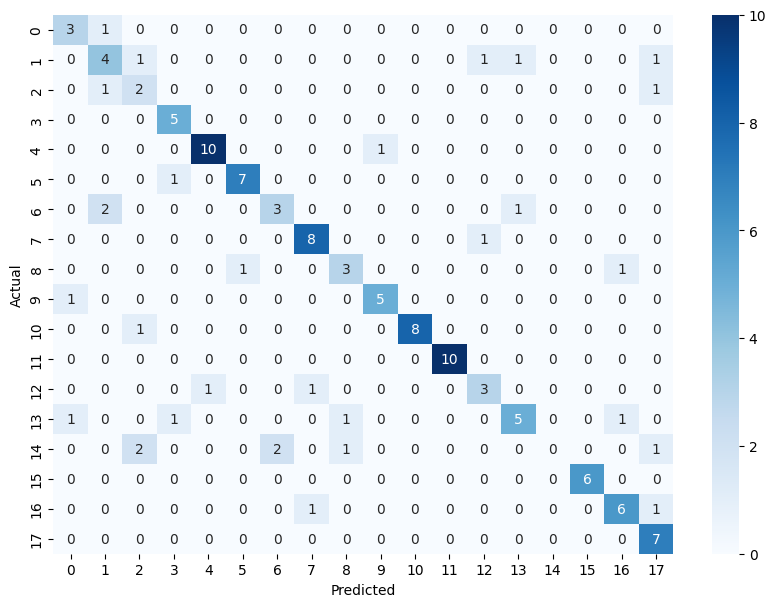

In [14]:
# SGDClassifier ile model oluşturma
model = SGDClassifier(alpha=1e-05, max_iter=50, penalty='elasticnet', random_state=42)

# Modeli eğitme
model.fit(X_train, y_train)

# Modelin performansını değerlendirme
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Test accuracy: {accuracy:.4f}')

# classification_report 
print(classification_report(y_test, y_pred))


# confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

Test accuracy: 0.8413
              precision    recall  f1-score   support

         aar       0.75      0.75      0.75         4
         bco       1.00      0.62      0.77         8
         cul       0.60      0.75      0.67         4
         cun       1.00      1.00      1.00         5
         ebr       1.00      0.91      0.95        11
         gur       1.00      0.75      0.86         8
         hin       0.86      1.00      0.92         6
         kaz       0.88      0.78      0.82         9
         lev       1.00      0.60      0.75         5
         msa       1.00      0.67      0.80         6
         oek       1.00      0.89      0.94         9
         psu       0.83      1.00      0.91        10
         sav       0.83      1.00      0.91         5
         tal       0.90      1.00      0.95         9
         ttu       1.00      0.33      0.50         6
         tug       1.00      1.00      1.00         6
         ved       0.64      0.88      0.74         8
     

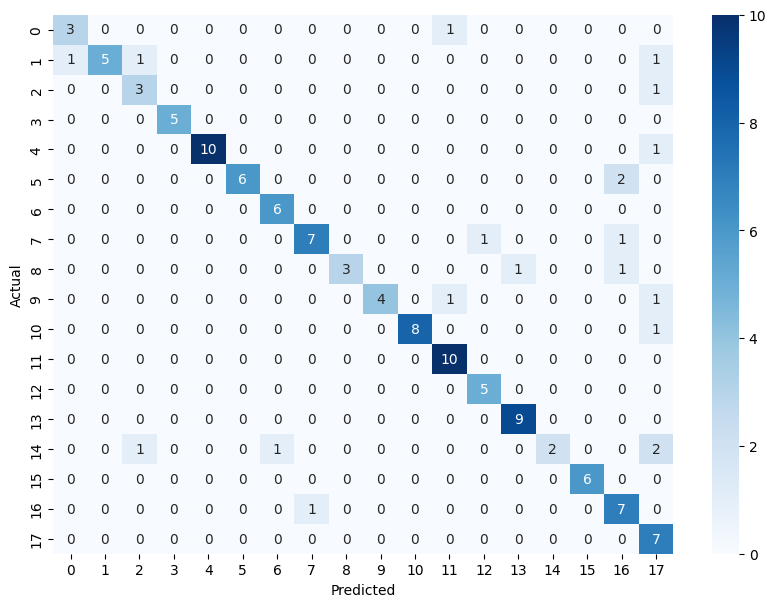

In [15]:
# SGDClassifier ile model oluşturma
model = SGDClassifier(alpha=0.001, max_iter=50, penalty='l2', random_state=42)

# Modeli eğitme
model.fit(X_train, y_train)

# Modelin performansını değerlendirme
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Test accuracy: {accuracy:.4f}')

# classification_report 
print(classification_report(y_test, y_pred))


# confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [16]:
param_grid = {
    'alpha': [1e-06, 1e-05, 0.0001, 0.001, 0.01],
    'max_iter': [50, 100, 200, 500, 1000],
    'penalty': ['elasticnet', 'l2', 'l1'],
    'l1_ratio': [0.15, 0.5, 0.7]  # Sadece 'elasticnet' için kullanılır
}

# GridSearchCV ile model oluşturma
grid_search = GridSearchCV(SGDClassifier(random_state=42), param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

# En iyi parametreleri ve skorları gösterme
print("En iyi parametreler:", grid_search.best_params_)
print("En iyi skor:", grid_search.best_score_)

# Çapraz doğrulama ile model performansını değerlendirme
cross_val_scores = cross_val_score(grid_search, X_test, y_test, cv=5)
print("Çapraz doğrulama skorları:", cross_val_scores)
print("Ortalama çapraz doğrulama skoru:", cross_val_scores.mean())

En iyi parametreler: {'alpha': 0.001, 'l1_ratio': 0.15, 'max_iter': 50, 'penalty': 'l2'}
En iyi skor: 0.7777425742574258


c:\Users\Umitk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
c:\Users\Umitk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
c:\Users\Umitk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
c:\Users\Umitk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
c:\Users\Umitk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_split.

Çapraz doğrulama skorları: [0.42307692 0.56       0.6        0.72       0.44      ]
Ortalama çapraz doğrulama skoru: 0.5486153846153846


Test accuracy: 0.8413
              precision    recall  f1-score   support

         aar       0.75      0.75      0.75         4
         bco       1.00      0.62      0.77         8
         cul       0.60      0.75      0.67         4
         cun       1.00      1.00      1.00         5
         ebr       1.00      0.91      0.95        11
         gur       1.00      0.75      0.86         8
         hin       0.86      1.00      0.92         6
         kaz       0.88      0.78      0.82         9
         lev       1.00      0.60      0.75         5
         msa       1.00      0.67      0.80         6
         oek       1.00      0.89      0.94         9
         psu       0.83      1.00      0.91        10
         sav       0.83      1.00      0.91         5
         tal       0.90      1.00      0.95         9
         ttu       1.00      0.33      0.50         6
         tug       1.00      1.00      1.00         6
         ved       0.64      0.88      0.74         8
     

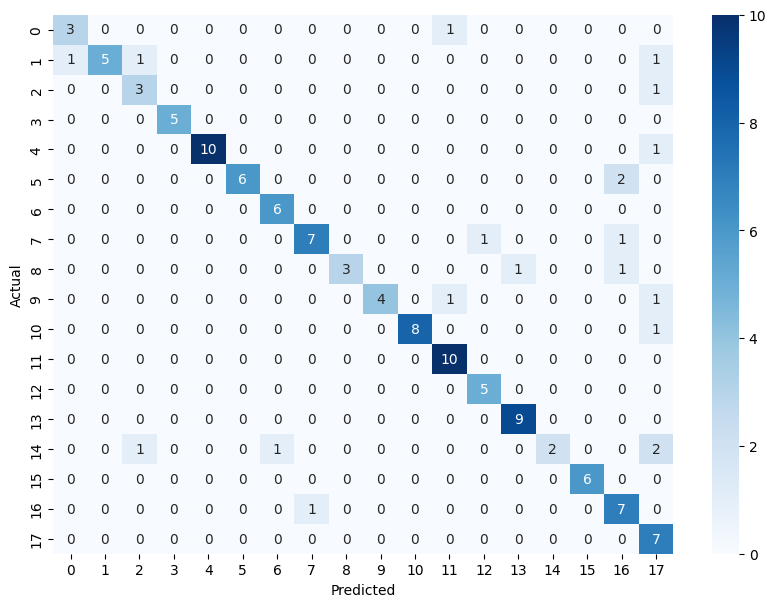

In [17]:
# SGDClassifier ile model oluşturma
model = SGDClassifier(alpha=0.001,l1_ratio=0.15, max_iter=50, penalty='l2', random_state=42)

# Modeli eğitme
model.fit(X_train, y_train)

# Modelin performansını değerlendirme
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Test accuracy: {accuracy:.4f}')

# classification_report 
print(classification_report(y_test, y_pred))


# confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()